In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("projB2.ipynb")

# Project B2: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Classification, and Cross-Validation


**Collaborators**: *list collaborators here*

## Introduction
In this project, I will build and improve on the concepts and functions you implemented in Project B1 to create a classifier to distinguish spam emails from ham (non-spam) emails. 

This outcomes of this project:

- Using `sklearn` libraries to process data and fit classification models.
- Validating the performance of the model and minimizing overfitting.
- Generating and analyzing ROC curves.

## Content Warning
This is a **real-world** dataset —— the emails being classified are actual spam and legitimate emails. 


In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import sys
import re

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

## Loading and Cleaning Data

In the email classification task, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Run the following cell to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [5]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email_raw'] = original_training_data['email']
original_training_data['email'] = original_training_data['email'].str.lower()
test['email_raw'] = test['email']
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam,email_raw
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0,URL: http://boingboing.net/#85534171\n Date: N...
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0,URL: http://scriptingnews.userland.com/backiss...
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0,Depends on how much over spending vs. how much...
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0,hehe sorry but if you hit caps lock twice the ...


In [6]:
# Fill any missing or NAN values.
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id           0
subject      6
email        0
spam         0
email_raw    0
dtype: int64
------------
After imputation:
id           0
subject      0
email        0
spam         0
email_raw    0
dtype: int64


## Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. Therefore, we split the training data into separate training and validation datasets. Once you have finished training, you will need this validation data to assess the performance of your classifier. 

In [7]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts.
train = train.reset_index(drop = True)

## Feature Engineering

We need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$ to train a logistic regression model. In Project B1, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this project, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional `NumPy` array containing one row for each email text. The row should contain a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

Run the following cell to see how the function works on some text.

In [8]:
from projB2_utils import words_in_texts

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

## EDA and Basic Classification

In Project B1, we visualized the frequency of different words in spam and ham emails and used `words_in_texts(words, train['email'])` to train a classifier directly. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `sklearn`.

Run the following cell to see the performance of a simple model using these words and the `train` `DataFrame`.

In [9]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [10]:
from sklearn.linear_model import LogisticRegression

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train)

training_accuracy = simple_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

In our models, we evaluate the accuracy of the training set, which may provide a misleading accuracy measure. In Project B1, we calculated various metrics to consider other ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="precision_recall.png" width="600px;" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Moving Forward

Make the spam filter more accurate. To determine your accuracy on the test set, you will use your classifier to predict every email in the `test` `DataFrame` and upload your predictions to Gradescope.


Here are some ideas for improving the model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, you can identify misclassified emails and see which relevant words are missing in your model.
1. Reducing dimensionality and/or multicollinearity. There are a few methods to achieve this:
    1. Implement PCA. Lectures [24](https://ds100.org/sp24/lecture/lec24/) and [25](https://ds100.org/sp24/lecture/lec25/) may be helpful.
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. Recall that you should use cross-validation for feature and model selection! Otherwise, you will likely overfit to your training data.
    1. Consider implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 4 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

To decide which features to use when building your model, it is helpful to conduct EDA. Show a visualization you used to select features for your model. 

<!-- BEGIN QUESTION -->

<br>

---

## Generate your visualization in the cell below.


In [11]:
def special_char_proportion(text, special_chars="$&#<>"):
    count_special_chars = sum(1 for char in text if char in special_chars)
    total_chars = len(text)
    
    if total_chars == 0:
        return 0.0
    
    return count_special_chars / total_chars
def calculate_capital_proportion(text):
    text = str(text)
    if text.strip() == '':
        return 0
    capital_count = sum(1 for c in text if c.isupper())
    total_chars = len(text.replace(' ', ''))
    return capital_count / total_chars

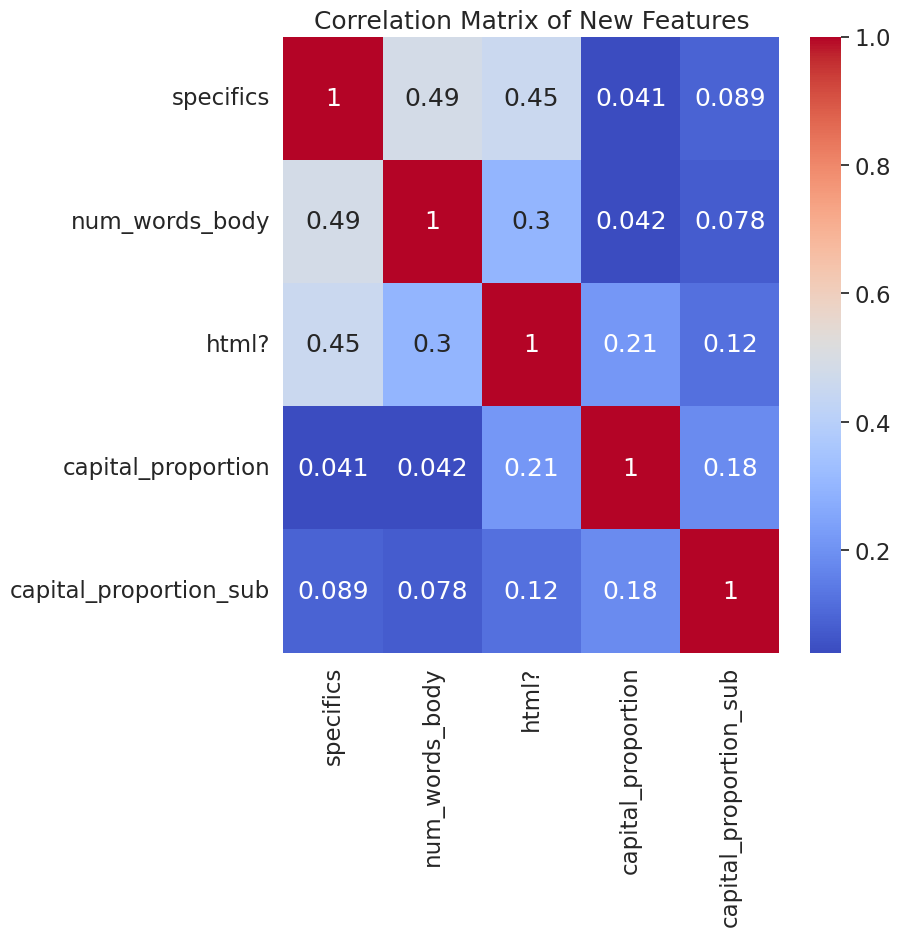

In [12]:
train_df = train.copy()
train_df['capital_proportion'] = train_df['email_raw'].apply(lambda x: calculate_capital_proportion(x))
train_df['capital_proportion_sub'] = train_df['subject'].apply(lambda x: calculate_capital_proportion(x))
train_df['subject_length'] = train_df['subject'].apply(len)
train_df['body_length'] = train_df['email'].apply(len)
specific_words = ['please', 'href', '</body>', '!!', 'click']
pattern = '|'.join(specific_words)
train_df['specifics'] = train_df['email'].str.count(pattern, flags=re.IGNORECASE)

train_df['num_words_body'] = train_df['email'].apply(lambda x: len(x.split()))
train_df['html?'] = train_df['email'].apply(lambda x: x.count('<html>'))
train_df['reply?'] = train_df['email'].apply(lambda x: x.count('reply'))

features = ["specifics", 'num_words_body', 'html?', "capital_proportion", 'capital_proportion_sub']
correlation_matrix = train_df[features].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of New Features')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## The plott and its implications with respect to the features.

The plotted heatmap shows the correlation matrix of the new features created from the text data in the training set. The values in the heatmap indicate the correlation coefficients between pairs of features, ranging from -1 to 1. A correlation close to 1 indicates a strong positive relationship, while a correlation close to -1 indicates a strong negative relationship. This visualization helps to understand how the new features are related to each other, which can be useful for feature selection and model building. For example, "specifics" contains two featured often found in html syntax, the body tag and "href", so "specifics" and "html?" have a strong correlation (close to 0.5). In this case it would not be wise to compute based on "specifics" and "html?" because there are closely related to the point that just one of them would give us the information we need. 

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Building My Own Model

In [ ]:
# import libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter

In [14]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!
# ...
# Define a processing function to create features from text data
def process_text_features(df):
    # Preprocess text data manually
    processed_text = df['email'].str.lower()  # Convert text to lowercase
    # Add more text preprocessing steps here as needed
    df['capital_proportion'] = df['email_raw'].apply(lambda x: calculate_capital_proportion(x))
    df['capital_proportion_sub'] = df['subject'].apply(lambda x: calculate_capital_proportion(x))
    specific_words = ['please', 'href', '</body>', '!!', 'click']
    pattern = '|'.join(specific_words)
    df['specifics'] = df['email'].str.count(pattern, flags=re.IGNORECASE)
    #df['special_char_prop'] = df['email_raw'].apply(lambda x: special_char_proportion(x, "\*"))
    #train_df['num_words_body'] = train_df['email'].apply(lambda x: len(x.split()))
    df['html?'] = df['email'].apply(lambda x: x.count('<html>'))
    df['reply?'] = df['email'].apply(lambda x: x.count('reply'))
    return df


# Create processed data with new text features
X_text = process_text_features(train)
#X_numeric = train_df[['subject_length','num_words_body', 'num_exclamations', 'special_char_proportion']]
X_numeric = train[["specifics", 'html?', "capital_proportion", "capital_proportion_sub", "reply?"]]

X = pd.concat([X_text, X_numeric], axis=1)
y = train['spam']

# split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_numeric, y, test_size=0.1, random_state=42)

# a logistic regression model
model = LogisticRegression()
model.fit(X_numeric, y)

# make predictions on the validation set
y_pred = model.predict(X_valid)

# evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.87
Confusion Matrix:
[[536  14]
 [ 85 117]]


<br>

---

# Train Predictions
Assign your predictions for the class of each data point in the training set `train` to `train_predictions`.

In [15]:
train_predictions = model.predict(X_numeric)

# Print your training accuracy. 
training_accuracy = np.mean(train_predictions == train_df["spam"])
training_accuracy


0.8844669239984028

<br>

---

## Test Predictions

The following code will write your predictions on the test dataset to a CSV file.

In [17]:
# perform the same text processing on the test data
X_text_test = process_text_features(test)
# extract numeric features for the test data
X_numeric_test = test[["specifics", 'html?', "capital_proportion", "capital_proportion_sub", "reply?"]]

# concatenate text and numeric features for test data
X_test = pd.concat([X_text_test, X_numeric_test], axis=1)

# make predictions on the test set using the trained model
test_predictions = model.predict(X_numeric_test)
test_predictions

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

<br/>
<hr style="border: 1px solid #fdb515;" />

# Analyzing The Model

<!-- BEGIN QUESTION -->

<br>

---

# The process of improving your model. 

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

1: to find which features would be useful, I first split the training data in to spam and not spam. then I took a feature i was considering and calculated what proportion of spam emails, and what proportion of not spam emails had that feature. then I computed the difference in the averages, to find out if there is a disparity between spam emails having that feature and not spam emails having that feature. 




2:  I tried general features like number of words, and number of characters. these were not polarizing enough to lead to a good classifier. Other features like the one we tried in project B1 proved to be more telling. spam emails had a lot more clickbait words than not spam emails. so I incorporated a feature that tracked the presence of words like "click", "now!", "please". This worked a lot better because spam emails use words like this at a dispropotionately high rate, compared to not spam emails. 



3: I was surprised about how easy it was to catch on to trends, I was surprised at how simple characteristics, seemingly non-important, could lead to a much better performing classifier. This meant that there are many nuanced features in an email that can make it spam, that a normal user might fall prey to since they cannot decern the threat as accurately as a mathematical model. Features like the proportion of an email body that is capitalized/ contains special characters.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

# ROC Curve

In most cases, we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late. In contrast, a patient can receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a particular class. To classify an example, we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, **we can adjust that cutoff threshold**. We can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve shows this trade-off for each possible cutoff probability. The cell below plots an ROC curve for the final classifier.

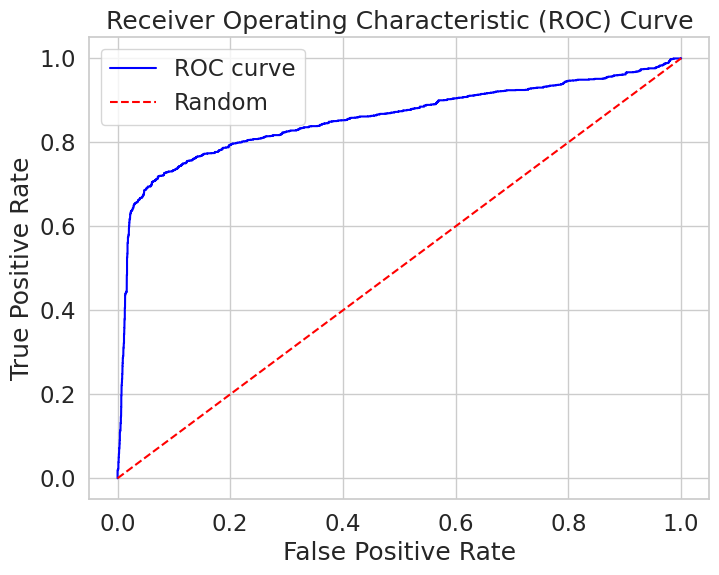

In [20]:
# Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_numeric)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob) #do the math


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Diving Deeper

So far, we’ve been looking at our model through the lens of accuracy. In the next two sections, we'll dive deeper into the complexities of analyzing our model's performance. In particular, we'll ask you to explore some ambiguous cases that can arise, even within the training data itself, and the consequences of misclassification. You may have already come across some of these cases unknowingly when building your model!

<br><br>

---

## Section 1

To help you better understand some of the challenges that arise with classification, we've selected three emails from the `train` `DataFrame` and provided them below. Each email highlights a different issue that could arise. 

### Example 1

In [21]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[5216]["spam"]))
print("\nemail:\n" + train.loc[5216]["email"])

spam: 1

email:
hello you two,
 
 i am so sorry catherine for not writing recently. i have just been vv busybeing a working mother and sometimes it all gets too much you know!! i cannot wait to see you both although we may meet at the airport on the 16/6 as that's the day we're going to france but i will see you both at bronagh's house for her 30th which we're going to on the way back from the airport. i am so excited about seeing you!!! liitle eva ( aine) was born on tuesday
  she is absolutely incredible. poor bronagh is 11 dsays over!!
 sounds like you've been having an amazing time. hope you won't be too depressed to be back!!
 
 lots of love
 
 deirdre
 "justin mason" <jm@jmason.org> wrote:
 
 <  
 <  just a quick note -
 <  
 <  we've decided to go up to annapurna base camp instead of
 <  the jomsom trek - it's a bit more impressive visually
 <  (if a little soggier).   so as of tomorrow morning, ourselves
 <  and our guide bhadra will be leaping like gazelles up 4000-odd
 <  met

### Example 2

In [22]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[36]["spam"]))
print("\nemail:\n" + train.loc[36]["email"])

spam: 0

email:
lifetime movie newsletter
 
 this week's movies to watch on lifetime
 
 [ http://www.lifetimetv.com/movies/index.html ]
 
 august 19, 2002
 
 *************************************************************************
 
 coming at you this week...
 
 1) "the secret life of zoey" premiere!
 2) the buzz about the upcoming movie
 3) movies airing this week
 4) big event: a martinez sunday
 5) fun and games
 
 *************************************************************************
 
 "the secret life of zoey" premiere!
 
 take a sneak peek at lifetimes next exciting original movie, "the secret life of zoey" [ http://www.lifetimetv.com/movies/info/move3195.html ], airing on monday, august 19 at 9 pm et/pt. zoey's mom thought she knew everything about her perfect teenage daughter. but when she realizes that her child is addicted to drugs, both of their worlds spin out of control. this dramatic film delves into the topic of teenage drug addiction and features stellar performer

### Example 3

In [23]:
# Just run this cell, don't modify it.

print("spam: " + str(train.loc[1092]["spam"]))
print("\nemail:\n" + train.loc[1092]["email"])

spam: 0

email:
this is a multi part message in mime format.
 
 --_nextpart_1_bvfoditvghtocxfdvjnkcuwblfv
 content-type: text/plain; charset="us-ascii"
 content-transfer-encoding: 7bit
 
 ........... with our telecoms partner bumblebee !
 
 don't get ripped off by expensive hotel, payphone and mobile charges. 
 save, save, save on international calls with ryanair's phone partner. 
 ************************************************************************
 *********
 
 you'll save up to 70% on international phone calls when you use our 
 online phone card.  you can use the card from any phone in any country 
 you visit and you won't have to worry about high phone charges 
 when you call home or the office.
 
 buying a card couldn't be easier and it's totally secure.  simply go to
 http://www.bumblebeecommunications.com/lowcostcalls/  
  to avail of this special offer for ryanair customers.
 
 it's another great deal from ryanair and our online phone 
 partner, bumblebee communications. 


<!-- BEGIN QUESTION -->

### Section 1 thoughts

The third email above contains common features of spam emails. We can just tell by the context of the email that it is promotional in nature, and encourages the reader to click on a link for a special offer, and could potentially lead to unsolicited marketing or phishing attempts. This does not align with the classification provided in the training data. Someone might disagree with this classification if they interpret the email as a legitimate communication from a company offering a genuine service. Some individuals may view promotional emails like this as valuable information rather than spam, especially if they have opted in to receive such offers or if they perceive the content as relevant to their interests. If someone had subcribed to this service externally and was recieving this email as a result, we can consider how this email could be not spam. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### How does the ambiguity in our labeled data (spam or ham) affect our understanding of the model's predictions and the way we measure/evaluate our model's performance?

Ambiguity in labeled data can introduce bias into the model during training. If there is inconsistency in how emails are labeled (spam or ham), the model may learn these inconsistencies and produce biased predictions. If the training data was made by someone who likes to subscribe to a lot of promotional material and labels several unsolicited ads as not spam, the model we build using this training data will not be effective for someone who prefers to not recieve any promotional data. Uncertainty in labeled data can affect the calculation of performance metrics such as accuracy, precision, recall, and F1 score. If there is disagreement on the ground truth labeling, it becomes challenging to assess the true performance of the model accurately. If there are disagreements on the ground truth, it becomes harder to provide meaningful feedback to refine the model and address potential weaknesses.

<br><br>

---

## Question 7

In Question 6, we explored the instability present in the “ground truth” and how this affects our evaluation of our model. Now, let's start thinking about your model's interpretability and what that means more broadly for an email classification task. A model is considered interpretable if humans can easily understand the reasoning behind its predictions and classifications.

### Question 7a

First, let's see if we can understand how our choice of features relates to how a particular email is classified. 

#### Part i

Let’s take a look at the `simple_model` we provided you earlier that uses 5 features. We have provided the code below for ease of reference. You will examine how a particular feature influences how an email is classified. 

In [24]:
# Simple model introduced at the start of this notebook. Just pay attention to the features.
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

simple_model = LogisticRegression()
simple_model.fit(X_train, Y_train);

Pick an email from the training set and assign its index to `email_idx`. Then, find **one** feature used in `simple_model` such that **removing** it changes how that email is classified. Assign this feature to  `feature_to_remove`.

In [25]:
# Use this cell for scratch work when determining `email_idx`
spams = train[train['spam'] == 1]
match_mask = spams[['email']].apply(lambda x: x.str.contains('bank')).any(axis=1)
spams[match_mask]["email"][27]

"dear opportunities seekers:\n \n i thought you just might be interested in the followings:\n \n we are currently hiring work home \n typist/clerk/secretary/supervisor/trainer/marketer/manager.we pay weekly\n 1000 usd \n potential. no experience ok. must know typing. no sex,age limit. part/full\n time. anywhere in \n the world. apply now!\n email: responsevivek@indiatimes.com and put i am interested in subject\n line for details. no spam. give it a chance.\n \n \n \n our business links:\n \n offshore banking high interests account. 300% per year\n after year.why\n just settle for 4%? since 1993.more info . responsevivek@indiatimes.com\n \n take advantage of our (malaysia)low currencies.buy\n cellular phones\n cheap. brand name :motorola,siemen etc. from 50 usd.brand\n new.guaranteed world lowest.good quality.all\n models.details : responsevivek@indiatimes.com. we also buy/sell\n second-hand cell phones. quality guaranteed.\n \n guaranteed world lowest phone rates.try use it yourself\n 

In [26]:
email_idx = 27

prob_spam = simple_model.predict_proba(X_train)[:, 1]
initial_prob = prob_spam[email_idx]
initial_class = "spam" if np.round(initial_prob) else "ham"
print(f"\nPredicted probability of being spam: {np.round(initial_prob*100, 2)}%")
print("\nEmail:\n" + train.loc[email_idx]["email"])


Predicted probability of being spam: 55.57%

Email:
dear opportunities seekers:
 
 i thought you just might be interested in the followings:
 
 we are currently hiring work home 
 typist/clerk/secretary/supervisor/trainer/marketer/manager.we pay weekly
 1000 usd 
 potential. no experience ok. must know typing. no sex,age limit. part/full
 time. anywhere in 
 the world. apply now!
 email: responsevivek@indiatimes.com and put i am interested in subject
 line for details. no spam. give it a chance.
 
 
 
 our business links:
 
 offshore banking high interests account. 300% per year
 after year.why
 just settle for 4%? since 1993.more info . responsevivek@indiatimes.com
 
 take advantage of our (malaysia)low currencies.buy
 cellular phones
 cheap. brand name :motorola,siemen etc. from 50 usd.brand
 new.guaranteed world lowest.good quality.all
 models.details : responsevivek@indiatimes.com. we also buy/sell
 second-hand cell phones. quality guaranteed.
 
 guaranteed world lowest phone rate

In [27]:
feature_to_remove = 'bank'

changed_words = some_words.copy()
changed_words.remove(feature_to_remove)

changed_model = LogisticRegression()
X_changed = words_in_texts(changed_words, train['email'])
y = train['spam']
changed_model.fit(X_changed, y)
changed_prob = changed_model.predict_proba(X_changed[[email_idx]])[:,1][0]
changed_class = "spam" if np.round(changed_prob) else "ham"

print(f"Initially classified as {initial_class} (Probability: {np.round(initial_prob*100, 2)}%)")
print(f"Now classified as {changed_class} (Probability: {np.round(changed_prob*100, 2)}%)")

Initially classified as spam (Probability: 55.57%)
Now classified as ham (Probability: 24.33%)


In [28]:
grader.check("q7ai")

q7ai results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Part ii

In 2-3 sentences, explain why you think the feature you chose to remove changed how your email was classified.

Email id 27, contained the word "banking", and was therefore caught by our simple model since one of the features we had was the word "bank". by removing the feature, email 27 was not flagged as spam and therefore the probability of it being classified as spam went down and it was then detected as ham

<!-- END QUESTION -->

### Question 7b

Now, let's say that instead of working with a small model containing 50-100 features, you're working with a much larger, more accurate model containing 1000 features. 

<!-- BEGIN QUESTION -->

#### Part i
In this context, do you think you could easily find a feature that could change an email's classification as you did in part a)? Why or why not?

In the context of working with a much larger, more accurate model containing 1000 features, it may not be as easy to find a single feature that could change an email's classification as was done with the smaller model. With a larger number of features, the interactions and dependencies between features become more complex, making it harder to pinpoint a specific feature that has a significant impact on the classification.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part ii 
Would you expect this new model to be more or less interpretable than `simple_model`?

**Note**: A model is considered interpretable if you can easily understand the reasoning behind its predictions and classifications. For example, the model we saw in part a), `simple_model`, is considered interpretable as we can identify which features contribute to an email's classification.

The new model with 1000 features would mostly be less interpretable compared to the simple_model with only 5 features. As the number of features increases, understanding the exact contribution of each feature to the model's predictions becomes harder to distinguish. The complexity introduced by a larger number of features can make it harder to interpret and explain the model's decisions in a simple and intuitive way.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7c

Now, imagine you’re a data scientist at Meta, developing a text classification model to decide whether to remove certain posts / comments on Facebook. In particular, you’re primarily working on moderating the following categories of content:
* Hate speech
* Misinformation 
* Violence and incitement

Pick one of these types of content to focus on (or if you have another type you’d like to focus on, feel free to comment on that!). What content would fall under the category you’ve chosen? Refer to Facebook’s [Community Standards](https://transparency.fb.com/policies/community-standards/), which outline what is and isn’t allowed on Facebook. 

I would focus on moderating content in the category of Violence, especially sexual violence perpetrated against minors. There is an undercover industry within the dark corners of social media that aims to exploit children and minors via production of sexually explicit/ violent content. This type of content should be heavily banned/fined and investigated throughout all forms of media, this includes images, external links, and explicit language. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7d

What are the stakes of misclassifying a post in the context of a social media platform? Comment on what a false positive or false negative means for the category of content you’ve chosen (hate speech, misinformation, or violence and incitement).

The stakes of misclassifying a post can be quite severe. Here are the implications of false positives and false negatives in this context:

False Positive:
If a post containing content related to sexual violence against minors is incorrectly flagged as benign or non-violent, it could lead to serious harm to the victims involved. It may perpetuate the cycle of abuse, enable predators to continue exploiting minors, and contribute to the dissemination of harmful content. Allowing such content to remain visible can result in significant emotional distress, trauma, and potential safety risks for the individuals affected. It undermines the platform's efforts to create a safe environment and protect vulnerable users.


False Negative:
Implications: On the other hand, although less consequential, if a post is mistakenly classified as containing sexual violence against minors when it does not, it could impact freedom of speech, legitimate discussions, and content sharing that is not harmful. It may lead to censorship of valid content, hindering open dialogue on important issues. It may create a perception of over-policing or censorship.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 7e

As a data scientist, why might having an interpretable model be useful when moderating content online?

Moderating content online, especially on a wide spread platform means content moderation decisions should be transparent and justifiable to the users. Having a model that consists of features that aim to keep content on the platform compliant with the mission of the company while protecting its users is a big plus in building trust with consumers. Also, in case there are legal requirements that are imposed by a governing agency, it is important to have a model that can be traced, edited, and understood by developers to allow for further analysis and improving the model's performance, reduce bias, and enhance accuracy in content classification.

<!-- END QUESTION -->

As you explored throughout this question, interpretability is incredibly important. However, it is equally important to note that interpretability on its own isn’t a fix to all the problems that may arise when moderating content or when building a model more generally. As we touched on in Project A2, these models don’t operate in a vacuum; they exist in a wider sociotechnical system. Everything from the data used to train these models to the metrics we choose to evaluate our models builds on that notion.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Mimi and Trouble congratulate you for finishing Project B2!

<div align="middle">
    <table style="width:75%">
      <tr align="center">
        <td><video controls src = "images/mimi.mp4" width = "250">animation</video>
        <td><img src="images/trouble2.jpeg" align="middle" width="325vw"/>
        <td><img src="images/trouble.jpeg" align="middle" width="325vw"/>
      </tr>
    </table>
  </div>

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSe0fBEJwt6aEfZxU3fh3llNk8rSWHj6Umq0km3wPqmFu0MlGA/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Project B2 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Project B2 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. 

**Please make sure you submit the following to the right assignments:**

* **Project B2 Coding:** Submit the zip file generated by using the `grader.export()` cell provided below.
* **Project B2 Written:** Gradescope will automatically submit the PDF from the zip file submitted earlier. You do not need to submit anything to this assignment yourself, but *please check that the submission went through properly and that all plots rendered correctly*.
* **Project B2 Test Set Predictions:** Submit the CSV file generated in `q3b`.

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [29]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/otter/check/notebook.py:470: UserWarning: Could not locate a PDF to include
  warnings.warn("Could not locate a PDF to include")
